In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from keras.models import Input, load_model, Model
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.applications import VGG16
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# Image Preprocessing

In [2]:
def get_data(posImagePath, negImagePath):
    X, y = [], []
    for files in os.listdir(posImagePath):
        fileName = os.path.join(posImagePath,files)
        img = np.array(Image.open(fileName).resize((224,224)), 'float32')
        img /= 255.0
        X.append(img)
        y.append(1)
    
    for files in os.listdir(negImagePath):
        fileName = os.path.join(negImagePath,files)
        img = np.array(Image.open(fileName).resize((224,224)), 'float32')
        img /= 255.0
        X.append(img)
        y.append(0)
    
    return np.array(X), np.array(y)

In [3]:
X_train, y_train = get_data("D:/algaeDataSet/WInfectionTrain", "D:/algaeDataSet/WoutInfectionTrain")

In [4]:
X_val, y_val = get_data("D:/algaeDataSet/WInfectionVal", "D:/algaeDataSet/WoutInfectionVal")

In [5]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=100)

## Training Images

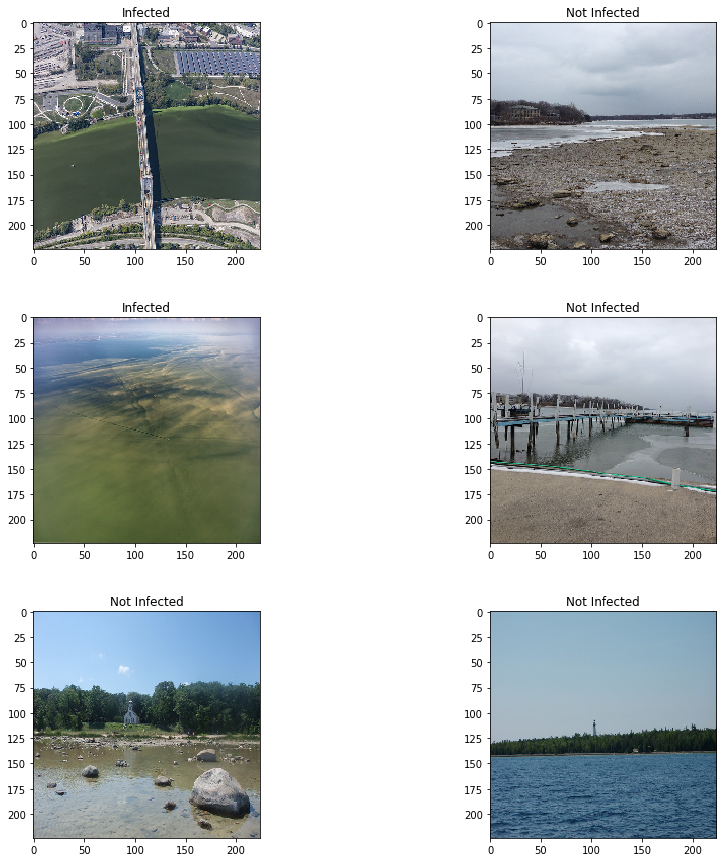

In [6]:
lab = lambda x : "Infected" if x==1 else "Not Infected"

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace = 0.3)
for n in range(3):
    axs[n][0].imshow(X_train[n])
    axs[n][0].set_title(lab(y_train[n])) 
    
    axs[n][1].imshow(X_train[n + 5])
    axs[n][1].set_title(lab(y_train[n + 5])) 

# Image classifier model using transfer learing

In [7]:
def get_model():
    inp_img = Input((224,224,3))
    
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inp_img)
    vgg16.trainable = False
    
    x = vgg16.output
    
    x = Flatten()(x)
    
    x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    out = Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-5))(x)
    
    model = Model(inputs = inp_img, output = out)
    
    return model

In [8]:
algaeClassifier = get_model()
algaeClassifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

C:\Users\klal1\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [9]:
algaeClassifier.compile(optimizer = Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history = algaeClassifier.fit(X_train, y_train, batch_size=4, epochs=5)

Epoch 1/5
95/95 [==============================] - 159s 2s/step - loss: 0.6663 - acc: 0.6316
Epoch 2/5
95/95 [==============================] - 153s 2s/step - loss: 0.3116 - acc: 0.8526
Epoch 3/5
95/95 [==============================] - 152s 2s/step - loss: 0.2956 - acc: 0.8947
Epoch 4/5
95/95 [==============================] - 152s 2s/step - loss: 0.2291 - acc: 0.8947
Epoch 5/5
95/95 [==============================] - 151s 2s/step - loss: 0.2895 - acc: 0.8632


In [10]:
predictions = algaeClassifier.predict(X_val)

# Confusion Matrix and Accuracy

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, np.round(predictions))
print(cm)
print("Accuracy on validation set is ", (cm[0][0] + cm[1][1])*100/y_val.shape)

[[15  0]
 [ 2 12]]
Accuracy on validation set is  [93.10344828]


# Predictions

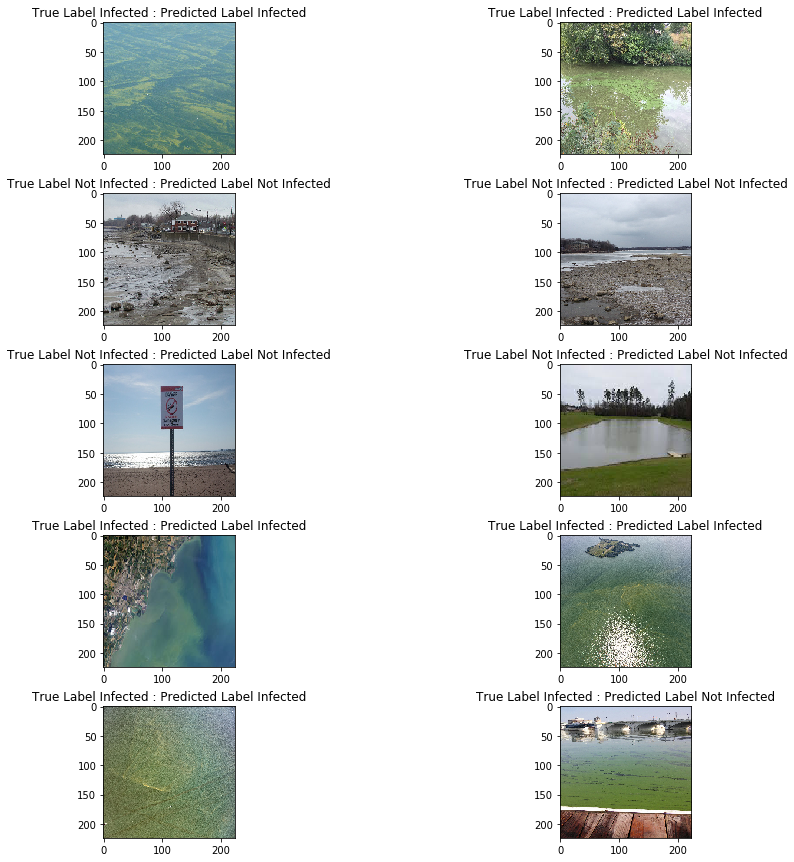

In [12]:
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
fig.subplots_adjust(hspace = 0.3)
for n in range(5):
    axs[n][0].imshow(X_val[n])
    axs[n][0].set_title("True Label " + lab(y_val[n]) + " : Predicted Label " + lab(np.round(predictions[n])))
    
    axs[n][1].imshow(X_val[n + 5])
    axs[n][1].set_title("True Label " + lab(y_val[n + 5]) + " : Predicted Label " + lab(np.round(predictions[n + 5])))

In [13]:
algaeClassifier.save('algaeClassifier.h5')